In [1]:
from pathlib import Path

import janitor
import pandas as pd
import plotnine as gg
import seaborn as sns

%config InlineBackend.figure_format='retina'

In [2]:
benchmark_dir = Path("../benchmarks/")
assert benchmark_dir.exists()
assert benchmark_dir.is_dir()

## Data Processing

Organization of benchmarks directory:

1. pipeline
2. rules
3. individual runs

> I may want to add more information to the name of the rules to keep them separate and not overwritten.
> For instance, including the date would be useful or metadata such as the data size for SBC or debug status for the fitting pipeline.

In [3]:
def process_benchmark_file(bench_f: Path) -> pd.DataFrame:
    return pd.read_csv(bench_f, sep="\t").assign(
        step=bench_f.name.replace(bench_f.suffix, "")
    )


def get_benchmark_data_for_rule_dir(rule_d: Path, pipeline_name: str) -> pd.DataFrame:
    bench_dfs: list[pd.DataFrame] = [
        process_benchmark_file(b) for b in rule_d.iterdir()
    ]
    return (
        pd.concat(bench_dfs)
        .assign(rule=rule_d.name, pipeline=pipeline_name)
        .clean_names()
    )


benchmark_df_list: list[pd.DataFrame] = []

for pipeline_dir in benchmark_dir.iterdir():
    for rule_dir in pipeline_dir.iterdir():
        benchmark_df_list.append(
            get_benchmark_data_for_rule_dir(rule_dir, pipeline_name=pipeline_dir.name)
        )

benchmark_df = pd.concat(benchmark_df_list).reset_index(drop=True)
benchmark_df.head()

,s,h_m_s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,step,rule,pipeline
0,1450.1557,0:24:10,2632.42,3493.61,2584.99,2607.41,725.83,95.04,10.12,146.76,sp4-default-fullrank_ADVI_perm12,run_sbc,012_010_simulation-based-calibration-snakemake
1,1438.7806,0:23:58,2626.87,3491.89,2624.31,2624.38,1881.28,97.78,10.29,148.10,sp4-default-fullrank_ADVI_perm6,run_sbc,012_010_simulation-based-calibration-snakemake
2,187.0007,0:03:07,2626.96,3567.98,2624.25,2624.31,44.03,91.66,63.26,118.45,sp4-default-fullrank_ADVI_perm0,run_sbc,012_010_simulation-based-calibration-snakemake
3,1500.0513,0:25:00,2659.00,3522.06,2656.29,2656.37,883.85,93.74,12.76,191.67,sp4-default-fullrank_ADVI_perm15,run_sbc,012_010_simulation-based-calibration-snakemake
4,242.4990,0:04:02,2744.32,3586.09,2741.89,2741.96,1889.93,102.59,45.52,110.58,sp4-default-fullrank_ADVI_perm19,run_sbc,012_010_simulation-based-calibration-snakemake


## Data dictionary

| colname | type (unit) | description |
|-------- |-------------|-------------|
| s | float (seconds) | Running time in seconds. |
| h:m:s	| string (-) | Running time in hour, minutes, seconds format. |
| max_rss | float (MB) | Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used. |
| max_vms | float (MB) | Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process. |
| max_uss | float (MB) | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now. |
| max_pss | float (MB) | “Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only). |
| io_in | float (MB) | The number of MB read (cumulative). |
| io_out | float (MB) | The number of MB written (cumulative). |
| mean_load | float (-) | CPU usage over time, divided by the total running time (first row). |
| cpu_time | float (-) | CPU time summed for user and system. |

## Data analysis and visualization

In [4]:
benchmark_df.groupby(["pipeline", "rule"]).mean().round(2)

s  max_rss  \
pipeline                                       rule                            
012_010_simulation-based-calibration-snakemake collate_sbc    19.85   226.52   
                                               run_sbc      1134.71  2667.23   

                                                            max_vms  max_uss  \
pipeline                                       rule                            
012_010_simulation-based-calibration-snakemake collate_sbc  1084.56   224.15   
                                               run_sbc      3535.64  2655.57   

                                                            max_pss    io_in  \
pipeline                                       rule                            
012_010_simulation-based-calibration-snakemake collate_sbc   224.22   281.31   
                                               run_sbc      2659.89  1137.86   

                                                            io_out  mean_load  \
pipeline                                       rule                             
012_010_simulation-based-calibration-snakemake collate_sbc    0.16      36.01   
                                               run_sbc       85.91      17.27   

                                                            cpu_time  
pipeline                                       rule                   
012_010_simulation-based-calibration-snakemake collate_sbc      7.53  
                                               run_sbc        128.89

In [5]:
benchmark_df_long = benchmark_df[
    ["pipeline", "rule", "step", "cpu_time", "max_rss", "mean_load", "cpu_time"]
].pivot_longer(["pipeline", "rule", "step"])

benchmark_df_long
# (
#     alt.Chart(benchmark_df_long)
#     .mark_boxplot(size=50)
#     .encode(
#         x="rule",
#         y=alt.Y("value", title=""),
#         row=alt.Row("variable", title=""),
#         column=alt.Column("pipeline"),
#     )
#     .properties(width=200, height=100)
#     .resolve_scale(y="independent")
# )

,pipeline,rule,step,variable,value
0,012_010_simulation-based-calibration-snakemake,run_sbc,sp4-default-fullrank_ADVI_perm12,cpu_time,146.76
1,012_010_simulation-based-calibration-snakemake,run_sbc,sp4-default-fullrank_ADVI_perm6,cpu_time,148.10
2,012_010_simulation-based-calibration-snakemake,run_sbc,sp4-default-fullrank_ADVI_perm0,cpu_time,118.45
3,012_010_simulation-based-calibration-snakemake,run_sbc,sp4-default-fullrank_ADVI_perm15,cpu_time,191.67
4,012_010_simulation-based-calibration-snakemake,run_sbc,sp4-default-fullrank_ADVI_perm19,cpu_time,110.58
...,...,...,...,...,...
99,012_010_simulation-based-calibration-snakemake,run_sbc,sp4-default-fullrank_ADVI_perm17,cpu_time,119.68
100,012_010_simulation-based-calibration-snakemake,run_sbc,sp4-default-fullrank_ADVI_perm4,cpu_time,108.73
101,012_010_simulation-based-calibration-snakemake,run_sbc,sp4-default-fullrank_ADVI_perm18,cpu_time,129.75
102,012_010_simulation-based-calibration-snakemake,run_sbc,sp4-default-fullrank_ADVI_perm5,cpu_time,138.75


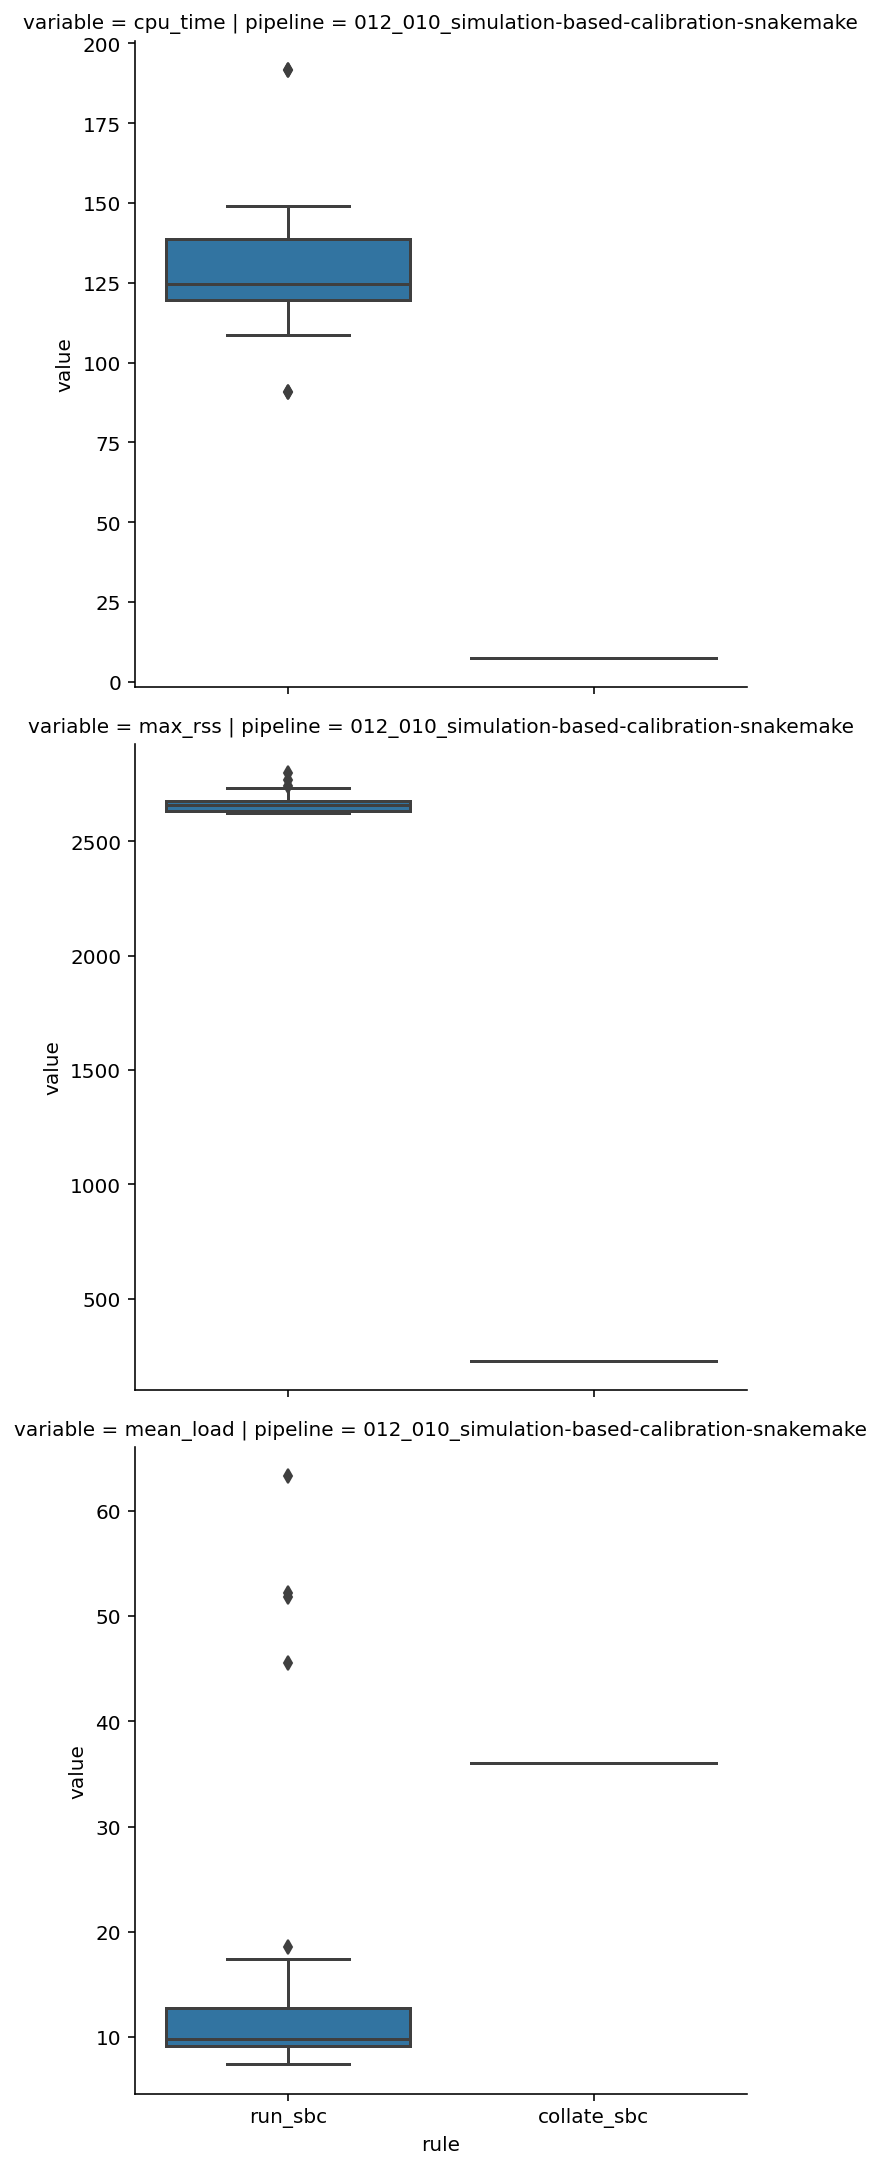

In [6]:
sns.catplot(
    data=benchmark_df_long,
    x="rule",
    y="value",
    kind="box",
    row="variable",
    col="pipeline",
    sharey=False,
);

---

In [7]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-22

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-230.o2.rc.hms.harvard.edu

Git branch: sp7-parameterizations

plotnine: 0.8.0
pandas  : 1.3.0
janitor : 0.21.0
seaborn : 0.11.1

